In [1]:
import pandas as pd
import numpy as np
import datetime
import time 
import os
import gc


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# '''/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
#   return getattr(obj, method)(*args, **kwds)'''

In [3]:
data_path = './data/'
!ls -lthr data/

total 43603864
-rw-------@ 1 sam_dessa  staff   246M 24 Mar 18:29 item_metadata.csv
-rw-------@ 1 sam_dessa  staff   510M 24 Mar 18:29 test.csv
-rw-------@ 1 sam_dessa  staff   2.0G 24 Mar 18:29 train.csv
-rw-------@ 1 sam_dessa  staff    51M 24 Mar 18:48 submission_popular.csv
-rw-r--r--  1 sam_dessa  staff   2.5G 28 Mar 00:54 result.csv
-rw-r--r--  1 sam_dessa  staff   9.7G 28 Mar 22:36 train.h5
-rw-r--r--  1 sam_dessa  staff    77M 31 Mar 00:46 session_fts.csv
-rw-r--r--  1 sam_dessa  staff    26M 31 Mar 00:47 meta_fts.csv
-rw-r--r--  1 sam_dessa  staff   5.7G 31 Mar 03:02 final.csv


In [4]:
def pshape(df):
    print(f'df len: {df.shape[0]:,}')

In [13]:
%%time
# nrows = 100000
nrows = None
train = pd.read_csv(data_path+'train.csv', nrows=nrows)

CPU times: user 20.4 s, sys: 1.71 s, total: 22.1 s
Wall time: 22.1 s


In [6]:
pshape(train)

df len: 15,932,992


In [5]:
test = pd.read_csv(data_path+'test.csv', nrows=None)
pshape(test)

df len: 3,782,335


In [59]:
sub = pd.read_csv(data_path+'submission_popular.csv')

In [60]:
sub.head()

,user_id,session_id,timestamp,step,item_recommendations
0,000324D9BBUC,89643988fdbfb,1541593942,10,924795 106315 1033140 119494 101758 903037 105...
1,0004Q49X39PY,9de47d9a66494,1541641157,1,3505150 3812004 2227896 2292254 3184842 222702...
2,0004Q49X39PY,beea5c27030cb,1541561202,1,4476010 3505150 3812004 2227896 2292254 222702...
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22854 3067559 22721 22713 16121 22772 22727 22...
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,9857656 5849628 655716 1352530 502066 1405084 ...


In [56]:
%%time
# encode action type info into reference ids, we do so by getting all the data from both train and test
action_train = pd.read_csv(data_path+'train.csv', usecols=['action_type', 'reference'])
action_test = pd.read_csv(data_path+'test.csv', usecols=['action_type', 'reference'])
action_cb = pd.concat([action_train, action_test], ignore_index=True)
del action_train, action_test
# remove rows whose action type is not ids
no_ids = ['search for poi', 'search for destination', 'filter selection', 'change of sort order']
action_cb = action_cb[~action_cb['action_type'].isin(no_ids)].reset_index(drop=True)
action_cb = action_cb.dropna().reset_index(drop=True)
is_id = action_cb['reference'].str.match('\d')
action_cb = action_cb[is_id].reset_index(drop=True)
action_cb['reference'] = action_cb['reference'].astype(int)

print('group on ids')
action_grp = action_cb.groupby('reference')['action_type']

group on ids
CPU times: user 29 s, sys: 1.93 s, total: 31 s
Wall time: 31 s


In [57]:
action_cb.reference

0            666856
1            666856
2            666856
3            109038
4            666856
5            109038
6            666856
7            109038
8            109038
9            109038
10           109038
11           109038
12           109038
13          1257342
14          3377332
15          3377332
16          3377332
17          3377332
18          3066244
19          3066244
20          3066244
21          3066244
22          3066244
23          3066244
24          3066244
25          3066244
26          3066244
27          3066244
28          3066244
29          3066244
             ...   
17349669    1668425
17349670    1668425
17349671    1668425
17349672    1668425
17349673    1668425
17349674    1668425
17349675    1668425
17349676    1668425
17349677    1668425
17349678    1668425
17349679    1668425
17349680    1668425
17349681    1668425
17349682    1668425
17349683    1668425
17349684    1668425
17349685    1668425
17349686    1668425
17349687    1668425


In [46]:
action_ctn = action_grp.value_counts()

In [47]:
action_ctn.head()

reference  action_type           
100000     clickout item              1
1000005    interaction item image    48
           clickout item              3
           search for item            3
           interaction item info      2
Name: action_type, dtype: int64

In [48]:
actions = list(action_cb.action_type.unique())


In [49]:
action_mapping = {v: k for k, v in enumerate(actions)}

In [13]:
action_mapping

{'interaction item image': 0,
 'clickout item': 1,
 'interaction item info': 2,
 'interaction item deals': 3,
 'interaction item rating': 4,
 'search for item': 5}

In [14]:
action_ctn_df = action_ctn.reset_index(name='ctn')
action_ctn_df = action_ctn_df[action_ctn_df.index.str.match('\d')].reset_index(drop=True)

In [15]:
action_ctn_df.head()

,reference,action_type,ctn
0,100000,clickout item,1
1,1000005,interaction item image,48
2,1000005,clickout item,3
3,1000005,search for item,3
4,1000005,interaction item info,2


In [16]:
action_ctn_df.shape

(939761, 3)

In [17]:
action_ctn_df['action_id'] = action_ctn_df['action_type'].map(action_mapping)

In [18]:
action_ctn_df.head()

,reference,action_type,ctn,action_id
0,100000,clickout item,1,1
1,1000005,interaction item image,48,0
2,1000005,clickout item,3,1
3,1000005,search for item,3,5
4,1000005,interaction item info,2,2


In [19]:
ohe = pd.DataFrame(np.eye(len(actions), dtype=int)[action_ctn_df.action_id.values], columns=actions)

In [20]:
ohe.head()

,interaction item image,clickout item,interaction item info,interaction item deals,interaction item rating,search for item
0,0,1,0,0,0,0
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,0,0,0,0,0,1
4,0,0,1,0,0,0


In [21]:
%%time
# (ohe*action_ctn_df['ctn'].values).head()
ohe = ohe.mul(action_ctn_df['ctn'], axis=0)

CPU times: user 31.3 ms, sys: 81.8 ms, total: 113 ms
Wall time: 24.4 ms


In [22]:
action_ctn_df = pd.concat([action_ctn_df, ohe], axis=1)

In [23]:
action_ctn_df.head()

,reference,action_type,ctn,action_id,interaction item image,clickout item,interaction item info,interaction item deals,interaction item rating,search for item
0,100000,clickout item,1,1,0,1,0,0,0,0
1,1000005,interaction item image,48,0,48,0,0,0,0,0
2,1000005,clickout item,3,1,0,3,0,0,0,0
3,1000005,search for item,3,5,0,0,0,0,0,3
4,1000005,interaction item info,2,2,0,0,2,0,0,0


In [24]:
action_ctn_df.head()

,reference,action_type,ctn,action_id,interaction item image,clickout item,interaction item info,interaction item deals,interaction item rating,search for item
0,100000,clickout item,1,1,0,1,0,0,0,0
1,1000005,interaction item image,48,0,48,0,0,0,0,0
2,1000005,clickout item,3,1,0,3,0,0,0,0
3,1000005,search for item,3,5,0,0,0,0,0,3
4,1000005,interaction item info,2,2,0,0,2,0,0,0


In [25]:
action_encoding = action_ctn_df.groupby('reference')[actions].sum()
# action_ctn_df.set_index('reference').groupby(level=0).sum()
# action_encoding[actions]/action_encoding.sum(axis=1)
normalized = action_encoding.div(action_encoding.sum(axis=1), axis=0)
normalized.head()

,interaction item image,clickout item,interaction item info,interaction item deals,interaction item rating,search for item
reference,,,,,,
100000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1000005,0.827586,0.051724,0.034483,0.000000,0.034483,0.051724
100001,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
10000234,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1000029,0.945055,0.043956,0.000000,0.010989,0.000000,0.000000


In [28]:
action_encoding = action_encoding.join(normalized, lsuffix='_ctn', rsuffix='_per',)

In [29]:
action_encoding.head()

,interaction item image_ctn,clickout item_ctn,interaction item info_ctn,interaction item deals_ctn,interaction item rating_ctn,search for item_ctn,interaction item image_per,clickout item_per,interaction item info_per,interaction item deals_per,interaction item rating_per,search for item_per
reference,,,,,,,,,,,,
100000,0,1,0,0,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1000005,48,3,2,0,2,3,0.827586,0.051724,0.034483,0.000000,0.034483,0.051724
100001,0,1,0,0,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
10000234,0,1,0,0,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1000029,86,4,0,1,0,0,0.945055,0.043956,0.000000,0.010989,0.000000,0.000000


In [42]:
action_encoding.reset_index()

,reference,interaction item image_ctn,clickout item_ctn,interaction item info_ctn,interaction item deals_ctn,interaction item rating_ctn,search for item_ctn,interaction item image_per,clickout item_per,interaction item info_per,interaction item deals_per,interaction item rating_per,search for item_per
0,100000,0,1,0,0,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1,1000005,48,3,2,0,2,3,0.827586,0.051724,0.034483,0.000000,0.034483,0.051724
2,100001,0,1,0,0,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3,10000234,0,1,0,0,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
4,1000029,86,4,0,1,0,0,0.945055,0.043956,0.000000,0.010989,0.000000,0.000000
5,10000338,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
6,10000360,0,1,0,0,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
7,1000041,573,162,14,10,14,28,0.715356,0.202247,0.017478,0.012484,0.017478,0.034956
8,10000412,0,2,0,0,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
9,1000043,0,3,1,0,1,1,0.000000,0.500000,0.166667,0.000000,0.166667,0.166667


In [44]:
action_encoding.index.str.match('\d')

array([ True,  True,  True, ..., False, False, False])

## NOTES
* the order of filter selection and what it selects is probably important, as it unrolls what the customer wants, maybe the order is not than important
    change of sort order add on top of this

## TO DOS:
* show feature importance

In [ ]:
train[train.action_type=='filter selection'].reference.nunique()

### clip sessions off to last click

In [ ]:
%%time
# get all rows upto the last clickout action (some rows has reference but it's not clickout action)
def up_to_last_click(grp):
    check = grp.action_type == 'clickout item'
    if check.sum() != 0:
        return grp.iloc[:np.argwhere(check)[-1][0]+1]
    else:
        return grp
        
train = train.groupby('session_id').apply(up_to_last_click).reset_index(drop=True)

In [14]:
%%time
# get utc timestamp
train['ts'] = train['timestamp'].apply(lambda t: datetime.datetime.utcfromtimestamp(t))

CPU times: user 8.08 s, sys: 445 ms, total: 8.52 s
Wall time: 8.52 s


In [7]:
%%time
# get utc timestamp
test['ts'] = test['timestamp'].apply(lambda t: datetime.datetime.utcfromtimestamp(t))

CPU times: user 1.98 s, sys: 108 ms, total: 2.08 s
Wall time: 2.08 s


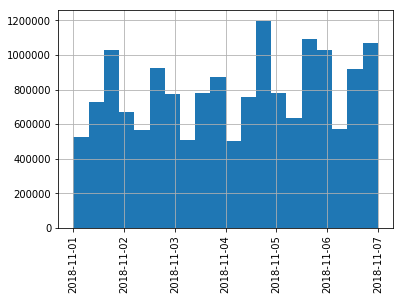

In [15]:
train.ts.hist(bins=20, xrot=90)

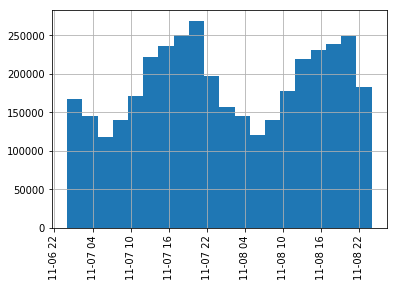

In [12]:
test.ts.hist(bins=20, xrot=90)

In [16]:
test.ts.head()

0   2018-11-07 01:53:34
1   2018-11-07 01:53:34
2   2018-11-07 01:54:56
3   2018-11-07 01:55:07
4   2018-11-07 01:55:17
Name: ts, dtype: datetime64[ns]

In [ ]:
%%time
# only look at sessions with clickouts (for now)
# first filter out sessions that does not have a click-out
def check_clickout(grp):
     # sessions has clickouts
    has_clickout = 'clickout item' in grp['action_type'].unique()
    # last row has reference and it's not nan
    has_ref = ((grp['action_type'].iloc[-1] == 'clickout item') & 
               (grp.iloc[-1][['impressions', 'reference', 'prices']].isna().sum()==0))
    return has_clickout & has_ref
    
clicked = train.groupby('session_id').apply(check_clickout)
click_session_ids = clicked[clicked].index
# filter
train = train[train.session_id.isin(click_session_ids)].reset_index(drop=True)

In [ ]:
# %%time
# # only look at sessions with clickouts (for now)
# # first filter out sessions that does not have a click-out
# def check_clickout(grp):
#      # sessions has clickouts
#     has_clickout = 'clickout item' in grp['action_type'].unique()
#     # last row has reference and it's not nan
#     has_ref = ((grp['action_type'].iloc[-1] == 'clickout item') & 
#                (pd.notnull(grp.iloc[-1]['impressions'])) &
#                (pd.notnull(grp.iloc[-1]['reference'])) &
#                (pd.notnull(grp.iloc[-1]['prices'])))
#     return has_clickout & has_ref
    
# clicked = train.groupby('session_id').apply(check_clickout)
# click_session_ids = clicked[clicked].index
# # filter
# train = train[train.session_id.isin(click_session_ids)].reset_index(drop=True)

In [ ]:
pshape(train)

In [ ]:
# d = train.groupby('session_id')
# for i, j in d:
#     print(j.head())
#     print('='*20)
#      # sessions has clickouts
#     has_clickout = 'clickout item' in j['action_type'].unique()
#     print(has_clickout)
#     # last row has reference and it's not nan
#     has_ref = ((j['action_type'].iloc[-1] == 'clickout item') & 
#                (pd.notnull(j.iloc[-1]['impressions'])) &
#                (pd.notnull(j.iloc[-1]['reference'])))
#     print(has_ref)
#     break

### meta info

In [34]:
%%time
meta = pd.read_csv(data_path+'item_metadata.csv', nrows=nrows)
meta['properties'] = meta['properties'].str.lower()

CPU times: user 2.58 s, sys: 268 ms, total: 2.85 s
Wall time: 2.85 s


In [35]:
# %%time
# # checkout properties of items
# def get_property_count(row):
#     return len(row.split('|'))



# item_p_ctn = meta['properties'].apply(get_property_count)
# item_p_ctn.describe()

In [36]:
%%time
def get_property(row):
    return row.lower().split('|')
# meta['ps'] = meta['properties'].apply(get_property)

meta['ps'] = meta['properties'].str.split('|')
# numer of properties
meta['nprop'] = meta.ps.str.len()
# star ratings
meta['star'] = meta.properties.str.extract('[\|](\d) star')
meta['star'] = meta['star'].astype(float)

CPU times: user 5.22 s, sys: 353 ms, total: 5.58 s
Wall time: 5.58 s


In [37]:
%%time
# # create rating columns
# ratings = ['good rating', 'satisfactory rating', 'excellent rating']
# for r in ratings:
#     meta[r.replace(' ', '_')] = meta.properties.str.findall(f'\|{r}').str.len()
    
    
def create_rating_colum(meta):
    # create rating columns
    ratings = ['good rating', 'satisfactory rating', 'excellent rating']
    for r in ratings:
        meta[r.replace(' ', '_')] = meta.properties.str.findall(f'\|{r}').str.len()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [38]:
def get_popularity(df):
    """Get number of clicks that each item received in the df."""

    mask = df["action_type"] == "clickout item"
    df_clicks = df[mask]
    df_item_clicks = (df_clicks
                      .groupby("reference")
                      .size()
                      .reset_index(name="n_clicks")
                      .transform(lambda x: x.astype(int)))
    return df_item_clicks

In [39]:
%%time
item_popularity = get_popularity(train)
meta = pd.merge(meta, item_popularity, left_on='item_id', right_on='reference')

CPU times: user 2.54 s, sys: 155 ms, total: 2.69 s
Wall time: 2.69 s


In [40]:
meta.head()

,item_id,properties,ps,nprop,star,reference,n_clicks
0,5101,satellite tv|golf course|airport shuttle|cosme...,"[satellite tv, golf course, airport shuttle, c...",62,4.0,5101,7
1,5416,satellite tv|cosmetic mirror|safe (hotel)|tele...,"[satellite tv, cosmetic mirror, safe (hotel), ...",46,4.0,5416,6
2,5834,satellite tv|cosmetic mirror|safe (hotel)|tele...,"[satellite tv, cosmetic mirror, safe (hotel), ...",40,3.0,5834,17
3,5910,satellite tv|sailing|cosmetic mirror|telephone...,"[satellite tv, sailing, cosmetic mirror, telep...",41,4.0,5910,7
4,6066,satellite tv|sailing|diving|cosmetic mirror|sa...,"[satellite tv, sailing, diving, cosmetic mirro...",85,4.0,6066,13


In [ ]:
meta = (meta[['item_id', 'nprop', 'n_clicks', 'star', 'good_rating', 'satisfactory_rating', 'excellent_rating']]
        .set_index('item_id'))

### Create session features
---

In [ ]:
# %%time
# # find out if same customers have multiple sessions
# s = train.drop_duplicates(subset=['user_id', 'session_id'])
# s.session_id.duplicated().sum()
# # seems like not

In [ ]:
# train.current_filters[:1000].unique()

In [ ]:
%%time
# def get_filters(x):
#     if type(x) == str or type(x) == list:
#         return x.split('|')
#     else:
#         return np.nan
    
# def get_impressions(x):
#     if type(x) == str:
#         return x.split('|')
#     else:
#         return np.nan
    
    
train['filters'] = train.current_filters.str.split('|')
train['nfilters'] = train.filters.str.len()
train['imps_list'] = train.impressions.str.split('|')
nn_mask = train['imps_list'].notnull()
train.loc[nn_mask, 'imps_list'] = train.loc[nn_mask, 'imps_list'].apply(lambda x: [int(i) for i in x])
train['nimps'] = train.imps_list.str.len()

In [ ]:
# train.nimps.describe()

In [ ]:
# # no switch of devices during session
# (train.groupby('session_id')['device'].nunique()!=1).sum()

In [ ]:
# # differnet city during session
# (train.groupby('session_id')['city'].nunique()!=1).sum()

In [ ]:
%%time
# some custom funcs used in agggregation
def mean_dwell_time(x):
    if len(x) == 1:
        return 0
    else:
        return np.mean(np.diff(np.sort(x)))
    
def var_dwell_time(x):
    if len(x) == 1:
        return 0
    else:
        return np.var(np.diff(np.sort(x)))
    
def get_first(x):
    return x.iloc[0]

def get_last(x):
    return x.iloc[-1]

def n_clickouts(x):
    return (x=='clickout item').sum()

def click_rel_pos_avg(x):
    return np.mean(np.argwhere((x=='clickout item')))/len(x)

def ptp(x):
    return x.max() - x.min()


# define some aggs
# session_aggs = {'timestamp': [np.ptp, mean_dwell_time, var_dwell_time],
session_aggs = {'timestamp': [ptp, mean_dwell_time, var_dwell_time],
                'step': ['max'],
                'action_type': ['nunique', n_clickouts, click_rel_pos_avg],
                'city': ['nunique', get_first],
                'platform': [get_first],
                'device': [get_first],
                'nfilters': ['mean', 'max', 'min', get_last],
                'nimps': ['max']
               }

In [ ]:
session_grp = train.groupby('session_id')

In [ ]:
%%time
# import os.path
session_file = 'session_fts.csv'
if os.path.isfile(session_file):
    session_fts = pd.read_csv(session_file)
else:
    session_fts = session_grp.agg(session_aggs)
    session_fts.columns = ['_'.join(col).strip() for col in session_fts.columns.values]
    session_fts.to_csv(session_file)

In [ ]:
# session_fts.columns.values
session_fts.head()

In [ ]:
# train[train.session_id=='62991f7c78f27']

### Create clickout features
---

In [ ]:
import multiprocessing as mp
from functools import partial


def get_session_item_pairs(args):
    # grab the args
    gids, session_df, meta_df = args
    # selecting the assigned session ids and grouping on session level
    grps = (session_df[session_df['session_id'].isin(gids)]
            .reset_index(drop=True)
            .groupby('session_id'))
    
    # use apply to compute session level features
    session_compute_func = partial(compute_session_item_pair, meta_df=meta_df)
    session_features = grps.apply(session_compute_func)
    
    return session_features
        
    
# def compute_session_item_pair(session_df, g_id, buy_df):
def compute_session_item_pair(session_df, meta_df):
    sdf = session_df.copy()
    last_row = sdf.iloc[-1]
    above = sdf.iloc[:-1]
    # get previous appeard impressions
    prev = above[above['impressions'].notnull()]
    prev_imps = prev['imps_list']
    unique_imps = [j for i in prev_imps for j in i]

    imp_l = last_row['imps_list']
    prices = last_row['prices'].split('|')
    prices = [int(p) for p in prices]
    # whether the impression appeared before
    appeared = [int(i in unique_imps) for i in imp_l]
    # the location of the impression
    locs = list(range(len(imp_l)))

    # build the df
    result = pd.DataFrame({'appeared': appeared, 'location': locs, 'price': prices}, index=imp_l)
    result.index.name = 'item_id'
    price_ind = np.argsort(result['price'].values) + 1
    result['rel_price_rank'] = price_ind/len(imp_l)
#     result['rel_price_rank'] = result[['location', 'price']].sort_values(by='price')['location']/len(imp_l)

    result['price_mean'] = np.mean(result['price'])
    result['price_median'] = np.median(result['price'])

    result_price = result['price'].values
    result_price_mean = result['price_mean'].values 
    result_price_median = result['price_median'].values

    result['diff_mean'] = result_price - result_price_mean
    result['diff_median'] = result_price - result_price_median
    result['diff_mean_rel'] = (result_price - result_price_mean)/result_price
    result['diff_median_rel'] = (result_price - result_price_median)/result_price

    # fetch the meta data
    result = result.join(meta_df, on='item_id')
    result['p_mean'] = np.mean(result['n_clicks'].values)
    result['star_mean'] = np.mean(result['star'].values)
    result['gr_mean'] = np.mean(result['good_rating'].values)
    result['sr_mean'] = np.mean(result['satisfactory_rating'].values)
    result['er_mean'] = np.mean(result['excellent_rating'].values)
    result.reset_index(inplace=True)

    # get target
    ref = int(last_row['reference'])
    result['target'] = (result['item_id'].values == ref).astype(int)
    return result


# 2) dwell time for each clickout
# 3) the rating and star and nproperty -> mean and median for 
#     the other impressions in list (or the quantile of these and prices)
# 4) location and relative location in the impressions list


def generate_session_item_pairs(sessions_df, meta_df, nprocs=None):
    t1 = time.time()
    if nprocs is None:
        nprocs = mp.cpu_count() - 1 
        print('Using {} cores'.format(nprocs))

    sids = sessions_df.session_id.unique()
    
    pairs = []
    # create iterator to pass in args
    def args_gen():
        for i in range(nprocs):
            yield (sids[range(i, len(sids), nprocs)], sessions_df, meta_df)
    
    # init multiprocessing pool
    pool = mp.Pool(nprocs)
    for pair in pool.map(get_session_item_pairs, args_gen()):
        pairs.append(pair)
    pool.close()
    pool.join()
    print('Done genearting, total time took: {0:.2f}mins'.format((time.time()-t1)/60))

    return pd.concat(pairs, axis=0)#, ignore_index=True)

In [ ]:
# %%time
# result_df = generate_session_item_pairs(train[train.session_id.isin(sids)], meta, nprocs=None)

In [ ]:
# %%time
# result_df = generate_session_item_pairs(train[:10000], meta, nprocs=None)

In [ ]:
%%time
result_df = generate_session_item_pairs(train, meta, nprocs=None)

In [ ]:
result_df.to_csv('./data/result.csv')

In [ ]:
result_df.shape

In [ ]:
meta.shape

In [ ]:
result_df.head()

In [ ]:
%%time
result_df = result_df.reset_index(level='session_id')

In [ ]:
%%time
# join on session features
result_df = result_df.set_index('session_id')

In [ ]:
%%time
final = result_df.join(session_fts)

In [ ]:
final.to_csv('./data/final.csv')

to do:

1) check the time range of train vs test

In [ ]:
final.head()

In [ ]:
train.ts.hist(bins=20)

In [ ]:
(train.ts <= datetime.datetime(2018,11,6)).sum()

In [ ]:
(train.ts > datetime.datetime(2018,11,6)).sum()

In [ ]:
train_sids = train[train.ts <= datetime.datetime(2018,11,6)].session_id.unique()

In [ ]:
final.head()

In [ ]:
# final.reset_index(name='session_id').head()
xtrain = final[final.index.isin(train_sids)]

In [ ]:
xval = final[~final.index.isin(train_sids)]

In [ ]:
xtrain.to_hdf('./data/train.h5', key='xtrain', mode='w')

In [ ]:
xtrain.to_hdf('./data/train.h5', key='xval', mode='a')